![Logo 01](https://staff.utia.cas.cz/novozada/dizo/DIZO003.png)

**Course website:** [http://zoi.utia.cas.cz/NPGR032](http://zoi.utia.cas.cz/NPGR032)

# Part 0: Imports Packages & Data & Helper Functions


In [1]:
!pip install opencv-contrib-python==4.4.0.44
import requests
import zipfile
import os
import errno
import cv2 as cv
# For showing the images in Colab use wrap function cv2_imshow
from google.colab.patches import cv2_imshow
import numpy as np
import numpy.matlib as npmat
import matplotlib.pyplot as plt
import time
import glob
import itertools
import os
from IPython import display
import math
import scipy
import scipy.signal as ss
import warnings
warnings.filterwarnings("ignore")

filename = 'DIZO003_data.zip'
url = f'http://staff.utia.cas.cz/novozada/dizo/{filename}'
try:  
    os.mkdir(f'{filename[:-4]}')    
    r = requests.get(url, allow_redirects=True)
    open(filename, 'wb').write(r.content)
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall("")        
except OSError as e:
    if e.errno != errno.EEXIST:
        raise
    else:
        print(f'{filename[:-4]} folder already exists!')

def resize(img, height=200, interpolation=cv.INTER_CUBIC):
  scale = height / img.shape[0]
  width = int(img.shape[1] * scale)
  new_size = (width, height)  
  return cv.resize(img, new_size, interpolation = interpolation)

def show(img, height=200, interpolation=cv.INTER_CUBIC):  
  img_new = resize(img, height, interpolation = interpolation)  
  cv2_imshow(img_new)

def show_list(imgs, height=100):  
  img_new = resize(imgs[0].astype(float), height)
  img_new = cv.normalize(img_new, None, 0, 255, cv.NORM_MINMAX)
  if len(imgs) > 1:
    for img in imgs[1:]:       
      img_ = cv.normalize(img, None, 0, 255, cv.NORM_MINMAX)
      img_new = cv.hconcat([img_new, resize(img_, height).astype(float)])            
  cv2_imshow(img_new)

def show_more(height, *args):
    img_new = cv.hconcat([resize(img, height).astype(float) for img in args])
    cv2_imshow(img_new)

def getFilenames(exts):
    fnames = [glob.glob(ext) for ext in exts]
    fnames = list(itertools.chain.from_iterable(fnames))
    fnames.sort()
    return fnames

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55.7 MB 255 kB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.6.0.66
    Uninstalling opencv-contrib-python-4.6.0.66:
      Successfully uninstalled opencv-contrib-python-4.6.0.66


# Part 1: Image Registration

Overlaying two or more images of the same scene:

*  Different viewpoints – multiview
*  Different times – multitemporal
*  Different modalities - multimodal
*  Scene to model registration

**Geometric distortion model:**
$$
\begin{aligned}
g = T_G(f)
\end{aligned}
$$

**The process:**

1.   Control point selection
2.   Control point matching
3.   Transform model estimation
4.   Image resampling and transformation

## Registration by Convolution


Reference: r


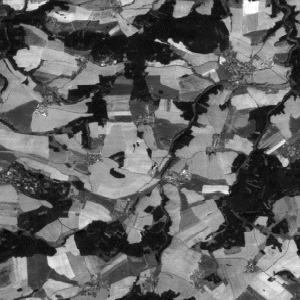

Template: t


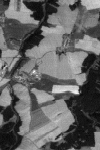

In [ ]:
ref = cv.imread('reference.png', cv.IMREAD_GRAYSCALE)
temp = cv.imread('template.png', cv.IMREAD_GRAYSCALE)
print('Reference: r')
show(ref, height=ref.shape[0])
print('Template: t')
show(temp, height=temp.shape[0])

1.   $c = r * t$
2.   Finding the coordinates of $\max(c)$
3.   Colour the found overlap

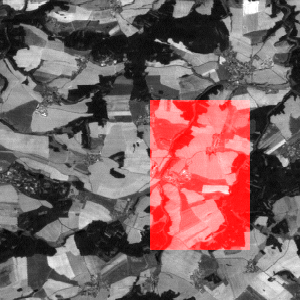

In [ ]:
def regconv(r, t):    
  c = cv.filter2D(r, ddepth=cv.CV_32F, kernel=t, borderType=cv.BORDER_CONSTANT)
  m, n = np.where(c == c.max())
  m, n = int(m[0]-t.shape[0]/2), int(n[0]-t.shape[1]/2)  
  h = np.stack((r,)*3, axis=-1)    
  h[m:m+t.shape[0], n:n+t.shape[1], 2] = 255
  return h

show(regconv(ref, temp), height=ref.shape[0])

Searching for some other region in the reference image:

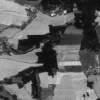

Result = 


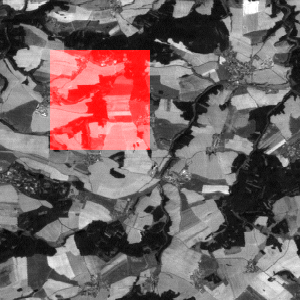

In [ ]:
ref_new = ref[50:150,50:150]
show(ref_new,height=ref_new.shape[0])
print('Result = ')
show(regconv(ref,ref_new), height=ref.shape[0])

What if this region is too small?

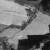

Result = 


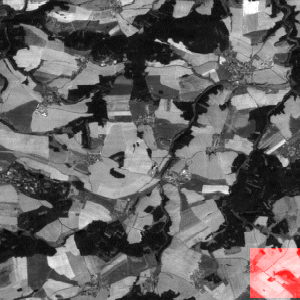

In [ ]:
ref_new = ref[50:100,50:100]
show(ref_new,height=ref_new.shape[0])
print('Result = ')
show(regconv(ref,ref_new), height=ref.shape[0])

Why?

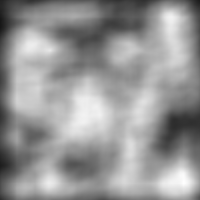

In [ ]:
c = cv.filter2D(ref, ddepth=cv.CV_32F, kernel=ref_new, borderType=cv.BORDER_CONSTANT)
show(c/c.max()*255)

## Registration by Summation of Pixels

1.   Create a rectangle of ones of the same size as the template image $= t_{ones}$
2.   $c = r * t_{ones}$
3.   Finding the coordinates of $c = \sum t$
4.   Colour the found overlap

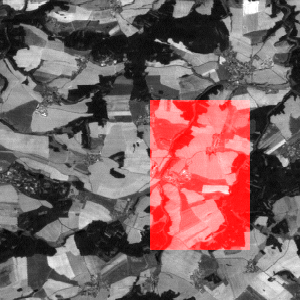

In [ ]:
def regsum(r, t): 
  r = r.astype(np.float)
  t = t.astype(np.float)
  tt = np.ones_like(t)   
  c = cv.filter2D(r, ddepth=cv.CV_32F, kernel=tt, borderType=cv.BORDER_CONSTANT)  
  m, n = np.where(c == t.sum())
  m, n = int(m[0]-t.shape[0]/2), int(n[0]-t.shape[1]/2)  
  h = np.stack((r,)*3, axis=-1)    
  h[m:m+t.shape[0], n:n+t.shape[1], 2] = 255
  return h

show(regsum(ref, temp), height=ref.shape[0])

Now it works correctly for small regions as well:

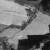

Result = 


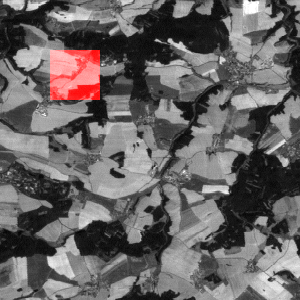

In [ ]:
ref_new = ref[50:100,50:100]
show(ref_new,height=ref_new.shape[0])
print('Result = ')
show(regsum(ref,ref_new), height=ref.shape[0])

Even if they are only a few pixels in size:

Result = 


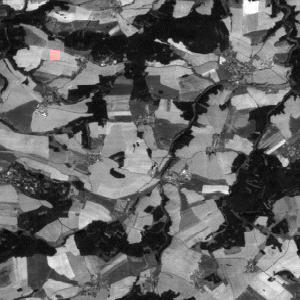

In [ ]:
ref_new = ref[50:60,50:60]
show(ref_new,height=ref_new.shape[0])
print('Result = ')
show(regsum(ref,ref_new), height=ref.shape[0])

## Registration by Phase Correlation

*  High computational speed
*  The algorithm modification leads to good robustness to noise
*  Limited to finding geometric transformations of TRS
  *  More complex transformations cannot be detected

The basis of this method is the - **Fourier Shift Theorem**:
$$
\begin{aligned}
\mathcal{F}_x[f(x-x_0)](k) = e^{-2\pi ikx_0}F(k)
\end{aligned}
$$

**Phase Correlation - Cross-power spectrum:**
$$
\mathcal{F}_x[f(x,y)] = F(u,v) \\
f(x,y) = w(x-a,y-b) \\
F(u,v) = W(u,v) \cdot e^{-2\pi ik(ua+vb)} \\
\frac{W \cdot F^*}{|W \cdot F|} = e^{-2\pi ik(ua+vb)}
$$
where

*  $F$ ... Fourier transform of the reference image
*  $F^*$ ... Complex conjugate
*  $W$ ... Fourier transform of the template image
*  $a,b$ ... Unknown shift

To obtain the shift parameters we use the IFT:
$$
IFT(e^{-2\pi ik(ua+vb)})=\delta(x-a, y-b)
$$

### Translation

Reference:


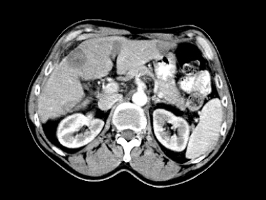

Translation:


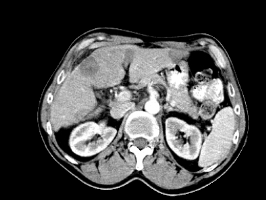

In [ ]:
ref = cv.imread('cut.png', cv.IMREAD_GRAYSCALE)
temp = cv.imread('cut_t.png', cv.IMREAD_GRAYSCALE)
print('Reference:')
show(ref)
print('Translation:')
show(temp)

Find the shift values

In [ ]:
def phacorr(t,r):
  R = np.fft.fft2(r)
  T = np.fft.fft2(t, s=r.shape)  
  pc = np.fft.ifft2( ( R * T.conj() ) / ( np.absolute(R)*np.absolute(T) ) )  
  m, n = np.where(pc == pc.max())
  # Visualisation of the peak  
  # show(abs(pc[10:30, 20:40]/pc.max()*255),200,interpolation=cv.INTER_NEAREST)    
  return int(m), int(n)

print(f'The shift is = {phacorr(ref, temp)}[down, right]  ')

The shift is = (20, 30)[down, right]  


## Registration by Point Matching

### Rotation around its axis

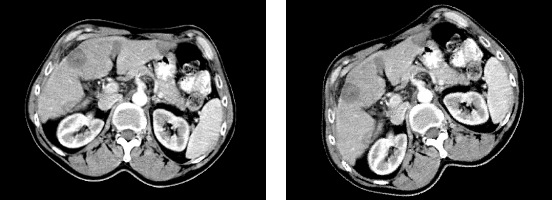

In [ ]:
ref = cv.imread('cut.png', cv.IMREAD_GRAYSCALE)
temp = cv.imread('cut_r.png', cv.IMREAD_GRAYSCALE)
show_more(200, ref, np.ones_like(ref[:,:50])*255,temp)

**We use polar coordinates** >>

In [ ]:
def cart2pol(x, y):
    rho = np.hypot(x, y)
    theta = np.arctan2(y, x)    
    theta[theta < 0] += 2 * np.pi
    return rho, theta

x = [1, -1, -1,  1]
y = [1,  1, -1, -1]

r, t = cart2pol(x,y)
print(f'{t * 180 / np.pi}°')

[ 45. 135. 225. 315.]°


1.   Select 3 identical points in both images
2.   Plot them in the images

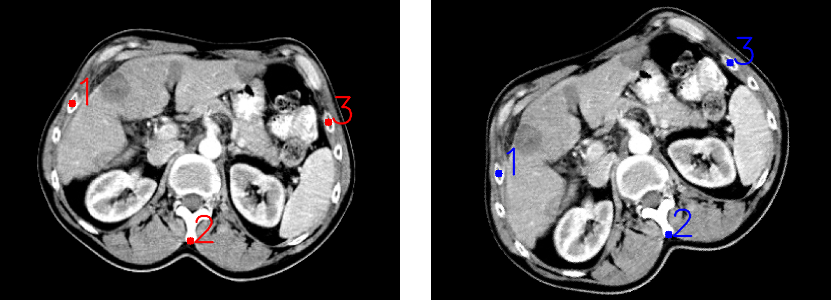

In [ ]:
ref = cv.imread('cut.png')
temp = cv.imread('cut_r.png')
points1 = np.array([[115, 165], [304, 385], [525, 195]])
points2 = np.array([[108, 277], [380, 375], [478, 100]])
font = cv.FONT_HERSHEY_SIMPLEX
for id, point in enumerate(points1): 
  cv.circle(ref, (point[0], point[1]), radius=1, color=(0, 0, 255), thickness=10)  
  cv.putText(ref, f'{id+1}', (point[0]+2, point[1]+2), font, 2, (0, 0, 255), 2, cv.LINE_AA)
for id, point in enumerate(points2): 
  cv.circle(temp, (point[0], point[1]), radius=1, color=(255, 0, 0), thickness=10)
  cv.putText(temp, f'{id+1}', (point[0]+2, point[1]+2), font, 2, (255, 0, 0), 2, cv.LINE_AA)
show_more(300, ref, np.ones_like(ref[:,:50])*255, temp) 

3.   Use these points to calculate the rotation of the image

In [ ]:
def hand_rot(img1, img2, p1, p2):
  # conversion to coordinates
  p1[:,0] = p1[:,0]-(img1.shape[1]/2)
  p1[:,1] = -(p1[:,1]-(img1.shape[0]/2))
  p2[:,0] = p2[:,0]-(img2.shape[1]/2)
  p2[:,1] = -(p2[:,1]-(img2.shape[0]/2))  
  
  r1, t1 = cart2pol(p1[:, 0],p1[:,1])
  r2, t2 = cart2pol(p2[:, 0],p2[:,1])

  rot = (t2 - t1) * 180 / np.pi      
  return sum(rot)/3;

points1 = np.array([[115, 165], [304, 385], [525, 195]])
points2 = np.array([[108, 277], [380, 375], [478, 100]])
ref = cv.imread('cut.png', cv.IMREAD_GRAYSCALE)
temp = cv.imread('cut_r.png', cv.IMREAD_GRAYSCALE)
rot = hand_rot(ref, temp, points1, points2)
print(f'The shift is = {rot:.3f} [°]  ')

The shift is = 29.806 [°]  


4.   Now try to rotate the image back

(320.0, 240.0)


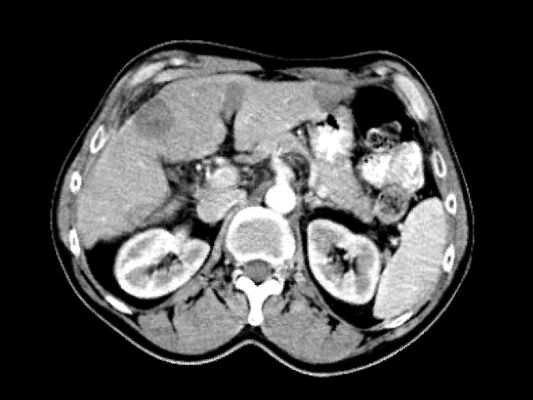

In [ ]:
def rotate_image(image, angle):
  image_center = tuple(np.array(image.shape[::-1]) / 2)
  print(image_center)
  rot_mat = cv.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv.INTER_CUBIC)
  return result
show(rotate_image(temp, -rot), 400)

### Afinne Transform

0.   Use these images - **bear.png** and **bear_t.png**
1.   Select 3 identical points in both images
2.   Plot them in the images

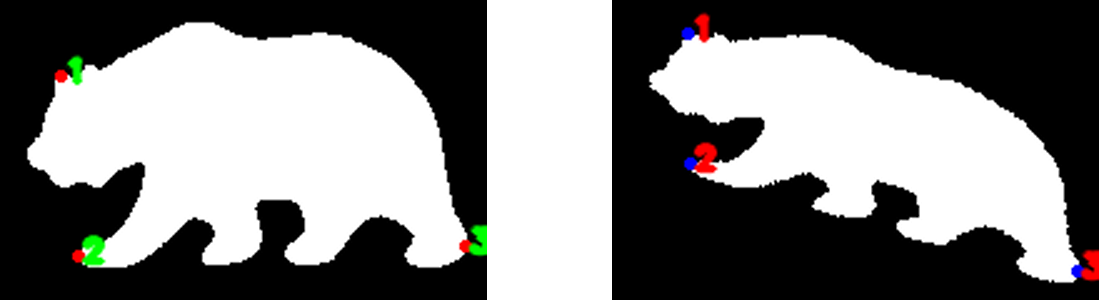

In [ ]:
ref = cv.imread('bear.png')
temp = cv.imread('bear_t.png')
points1 = np.array([[24, 30], [31, 102], [186, 98]])
points2 = np.array([[30, 13], [31, 65], [186, 108]])
font = cv.FONT_HERSHEY_SIMPLEX
for id, point in enumerate(points1): 
  cv.circle(ref, (point[0], point[1]), radius=1, color=(0, 0, 255), thickness=2)
  cv.putText(ref, f'{id+1}', (point[0]+2, point[1]+2), font, 0.4, (0, 255, 0), 2, cv.LINE_AA)
for id, point in enumerate(points2): 
  cv.circle(temp, (point[0], point[1]), radius=1, color=(255, 0, 0), thickness=2)
  cv.putText(temp, f'{id+1}', (point[0]+2, point[1]+2), font, 0.4, (0, 0, 255), 2, cv.LINE_AA)
show_more(300, ref, np.ones_like(ref[:,:50])*255, temp) 

**Using [OpenCV function](https://docs.opencv.org/3.4/d4/d61/tutorial_warp_affine.html):**

[[ 0.96781839  0.11600349 -6.54259698]
 [-0.41212424  1.39254085 24.26069602]]


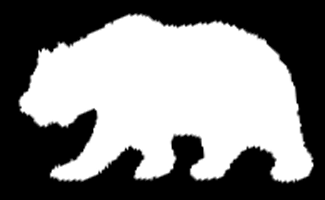

In [ ]:
ref = cv.imread('bear.png', cv.IMREAD_GRAYSCALE)
temp = cv.imread('bear_t.png', cv.IMREAD_GRAYSCALE)
points1 = np.array([[24, 30], [31, 102], [186, 98]]).astype(np.float32)
points2 = np.array([[30, 13], [31, 65], [186, 108]]).astype(np.float32)
warp_mat = cv.getAffineTransform(points2, points1)
print(warp_mat)
warp_dst = cv.warpAffine(temp, warp_mat, (temp.shape[1], temp.shape[0]))
show(warp_dst)

**From scratch:** using Least Squares Method

Affine transform:
$$
\begin{aligned}
v_0 = t_{00}u_0+t_{01}u_0+p_0 \\
v_1 = t_{10}u_0+t_{11}u_0+p_1 
\end{aligned}
$$

$$
\begin{aligned}
y = Ax
\end{aligned}
$$

$$
\begin{aligned}
y = \begin{bmatrix}
    v_0 & v_1
  \end{bmatrix}, A=\begin{bmatrix}
    u_0 & u_1 & 1
  \end{bmatrix}, x=
  \begin{bmatrix}
    t_{00} & t_{01} \\
    t_{10} & t_{11} \\
    p_{0} & p_{1} 
  \end{bmatrix}
\end{aligned}
$$
where
*   $T = \begin{bmatrix}
    t_{00} & t_{01} \\
    t_{10} & t_{11}    
  \end{bmatrix}$ ... Transformation coefficients (without shift)
*   $P=\begin{bmatrix}
    p_0 & p_1
  \end{bmatrix}$ ... Shift coefficients

Method of least squares:
$$
\begin{aligned}
x = (A^TA)^{-1}A^Ty
\end{aligned}
$$

To make them the same shape as OpenCV, we need to use their transpose: $x'$

[[ 0.96781839  0.11600349 -6.54259698]
 [-0.41212424  1.39254085 24.26069602]]
[[ 0.96781839  0.11600349 -6.54259698]
 [-0.41212424  1.39254085 24.26069602]]


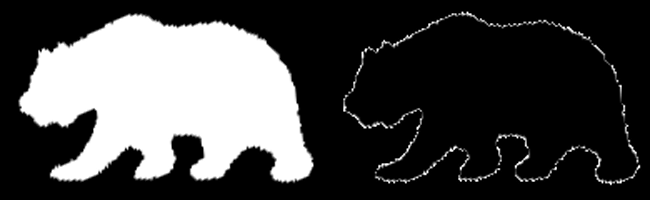

In [ ]:
def getAT(p1, p2):
  A = np.hstack((p1, np.ones((p1.shape[0],1))))
  y = p2
  x = np.transpose(((np.linalg.inv(np.transpose(A) @ A)) @ np.transpose(A)) @ y)
  return x

at = getAT(points2, points1)
print(at)
print(warp_mat)

warp_img = cv.warpAffine(temp, at, (temp.shape[1], temp.shape[0]))
show_more(200, warp_img, ref-warp_img)

### Automatic points detection - Panorama

Merging panoramic images - based on calculated feature points

![Ex101.1](https://staff.utia.cas.cz/novozada/dizo/panorama.jpg)


**Our data:**

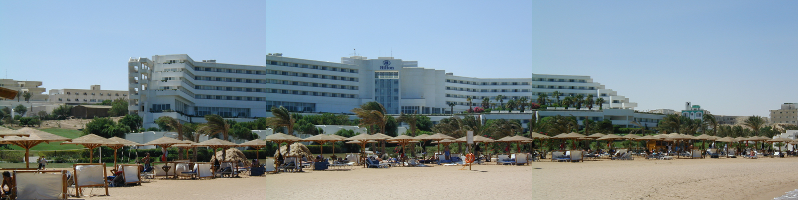

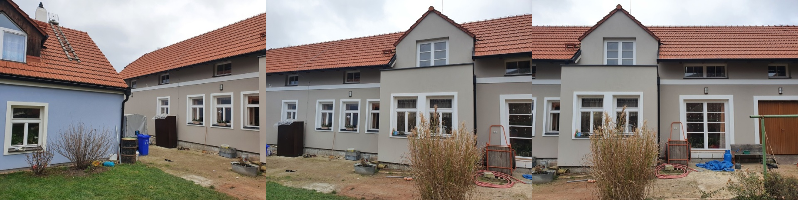

In [ ]:
fis1 = glob.glob('./panorama02/*.png')
fis2 = glob.glob('./panorama01/*.png')
fis1.sort()
fis2.sort()
imgs1 = []
imgs2 = []
for fi in fis1:
    img = cv.imread(fi)    
    imgs1.append(img)
for fi in fis2:
  img = cv.imread(fi)    
  imgs2.append(img)

show_more(200, imgs1[0],imgs1[1], imgs1[2])
show_more(200, imgs2[0],imgs2[1], imgs2[2])

**Using [OpenCV function](https://docs.opencv.org/3.4/d2/d8d/classcv_1_1Stitcher.html):**

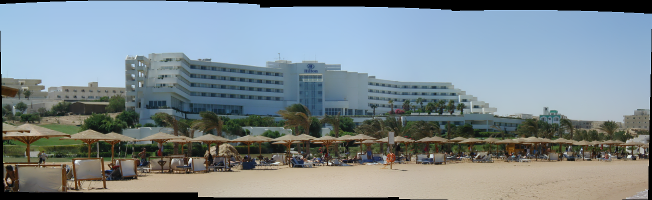

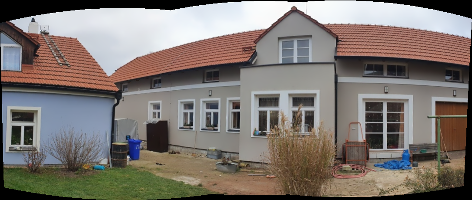

In [ ]:
stitcher = cv.Stitcher.create(cv.STITCHER_PANORAMA)
status1, pano1 = stitcher.stitch(imgs1)
status2, pano2 = stitcher.stitch(imgs2)

show(pano1)
show(pano2)

**Let's try it ourselves:**

1.   Convert to grayscale

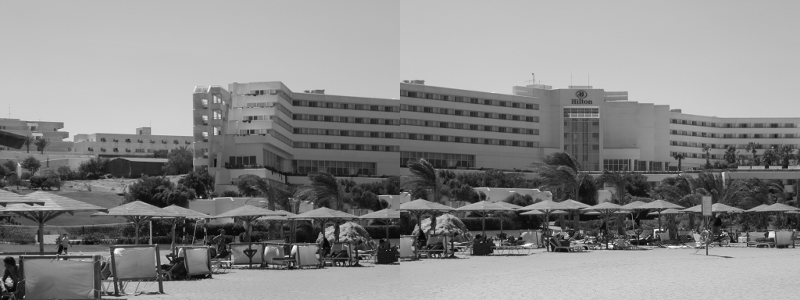

In [ ]:
img1 = imgs1[0]
img2 = imgs1[1]
img1_g = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
img2_g = cv.cvtColor(img2, cv.COLOR_BGR2GRAY)
show_more(300, img1_g, img2_g)

2.  Calculate the candidate points in both images - we will use BRISK

**[BRISK](https://ieeexplore.ieee.org/abstract/document/6126542)** is a feature point detection and description algorithm with scale invariance and rotation invariance, developed in 2011 as a free alternative to **[SIFT](https://link.springer.com/article/10.1023/B:VISI.0000029664.99615.94)**.

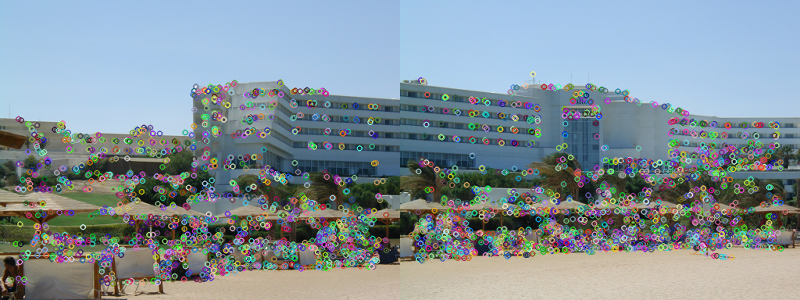

In [ ]:
brisk = cv.BRISK_create()
kp1, des1 = brisk.detectAndCompute(img1_g,None)
kp2, des2 = brisk.detectAndCompute(img2_g,None)
show_more(300, cv.drawKeypoints(img1,kp1,None), cv.drawKeypoints(img2,kp2,None))

3.  Match the candidate points and create their pairs

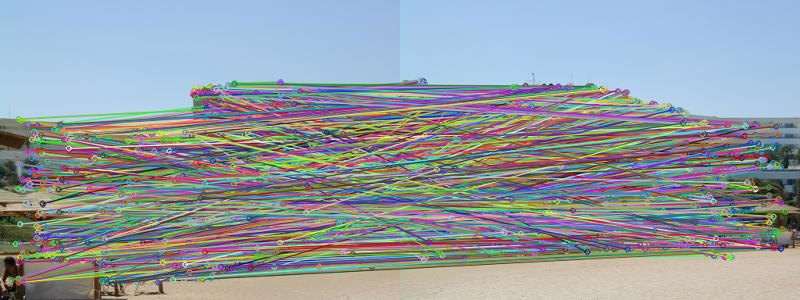

In [ ]:
dm = cv.DescriptorMatcher_create("BruteForce-Hamming")  
matches = dm.knnMatch(des1,des2, 2)
show(cv.drawMatchesKnn(img1,kp1,img2,kp2,matches,None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS), 300)

Ugh, that's a bit much.

4.  To eliminate inaccurate points we use Low’s ratio test


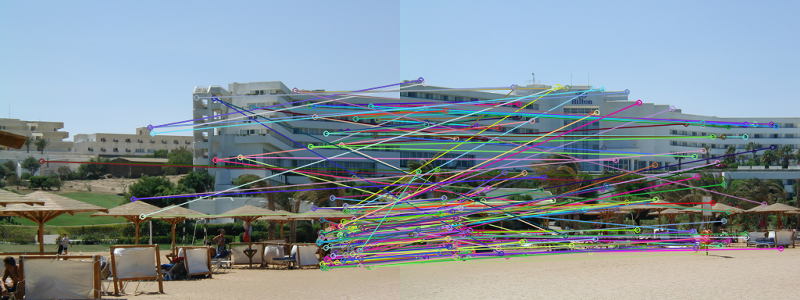

In [ ]:
matches = dm.knnMatch(des1,des2, 2)
matches_ = []
good = []
for m in matches:
    if len(m) == 2 and m[0].distance < m[1].distance * 0.75:
        matches_.append((m[0].trainIdx, m[0].queryIdx))
        good.append(m)
show(cv.drawMatchesKnn(img1,kp1,img2,kp2,good,None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS), 300)

5.  Now, we can count the Homography and warp the second image according to it

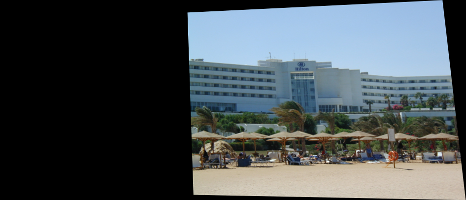

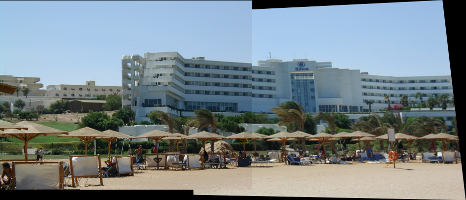

In [ ]:
kp1_ = np.float32([kp1[m[1]].pt for m in matches_]).reshape(-1,1,2)
kp2_ = np.float32([kp2[m[0]].pt for m in matches_]).reshape(-1,1,2)

H, mask = cv.findHomography(kp2_,kp1_, cv.RANSAC, 4.0)
h1,w1 = img1.shape[:2]
h2,w2 = img2.shape[:2]

pts1 = np.float32([[0,0],[0,h1],[w1,h1],[w1,0]]).reshape(-1,1,2)
pts2 = np.float32([[0,0],[0,h2],[w2,h2],[w2,0]]).reshape(-1,1,2)

pts2_ = cv.perspectiveTransform(pts2, H)
pts = np.concatenate((pts1, pts2_), axis=0)

[xmin, ymin] = np.int32(pts.min(axis=0).ravel() - 0.5)
[xmax, ymax] = np.int32(pts.max(axis=0).ravel() + 0.5)

t = [-xmin,-ymin]

Ht = np.array([[1,0,t[0]],[0,1,t[1]],[0,0,1]])

im = cv.warpPerspective(img2, Ht.dot(H), (xmax-xmin, ymax-ymin))
show(im)
im[t[1]:h1+t[1],t[0]:w1+t[0]] = img1
show(im)

Here are all the 5 steps together in the funciton `myStitcher`

In [ ]:
def myStitcher(img1, img2, transparent=False):               
    img1_g = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
    img2_g = cv.cvtColor(img2, cv.COLOR_BGR2GRAY)
    
    # BRISK keypoints
    brisk = cv.BRISK_create()
    kp1, des1 = brisk.detectAndCompute(img1_g,None)
    kp2, des2 = brisk.detectAndCompute(img2_g,None)
    
    # use BruteForce algorithm to detect matches among image keypoints 
    dm = cv.DescriptorMatcher_create("BruteForce-Hamming")
    
    matches = dm.knnMatch(des1,des2, 2)
    matches_ = []
    for m in matches:
        if len(m) == 2 and m[0].distance < m[1].distance * 0.75:
            matches_.append((m[0].trainIdx, m[0].queryIdx))
    
    kp1_ = np.float32([kp1[m[1]].pt for m in matches_]).reshape(-1,1,2)
    kp2_ = np.float32([kp2[m[0]].pt for m in matches_]).reshape(-1,1,2)
    
    
    H, mask = cv.findHomography(kp2_,kp1_, cv.RANSAC, 4.0)
    h1,w1 = img1.shape[:2]
    h2,w2 = img2.shape[:2]
    
    pts1 = np.float32([[0,0],[0,h1],[w1,h1],[w1,0]]).reshape(-1,1,2)
    pts2 = np.float32([[0,0],[0,h2],[w2,h2],[w2,0]]).reshape(-1,1,2)
    
    pts2_ = cv.perspectiveTransform(pts2, H)
    pts = np.concatenate((pts1, pts2_), axis=0)
    
    [xmin, ymin] = np.int32(pts.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(pts.max(axis=0).ravel() + 0.5)
    
    t = [-xmin,-ymin]
    
    Ht = np.array([[1,0,t[0]],[0,1,t[1]],[0,0,1]])
    
    #warp the colour version of image2
    im = cv.warpPerspective(img2, Ht.dot(H), (xmax-xmin, ymax-ymin))
    
    #overlay colur version of image1 to warped image2
    if transparent == True:
        h3,w3 = im.shape[:2]
        bim = np.zeros((h3,w3,3), np.uint8)
        bim[t[1]:h1+t[1],t[0]:w1+t[0]] = img1        
        im = cv.addWeighted(im,0.6,bim,0.6,0)
    else:
        im[t[1]:h1+t[1],t[0]:w1+t[0]] = img1
    return(im)

Try with each pair of pictures

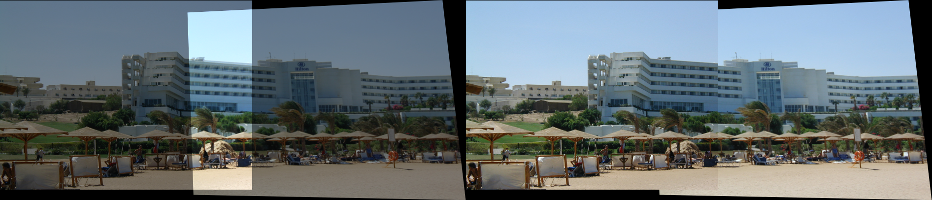

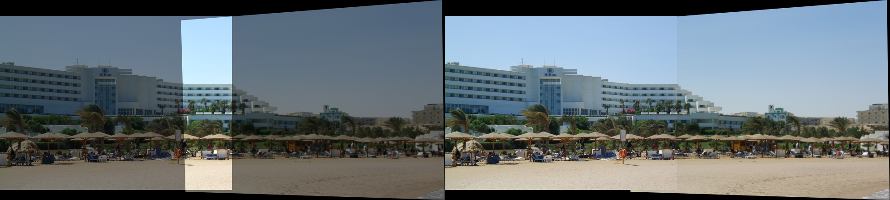

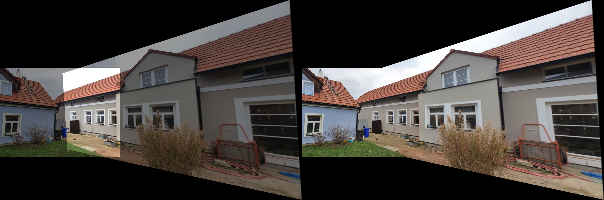

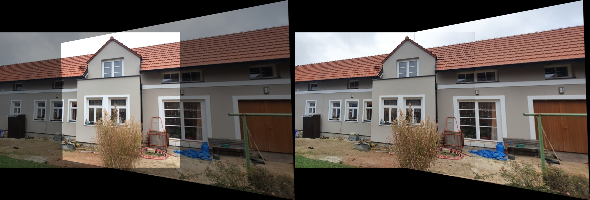

In [ ]:
show_more(200, myStitcher(imgs1[0], imgs1[1], True), myStitcher(imgs1[0], imgs1[1], False))
show_more(200, myStitcher(imgs1[1], imgs1[2], True), myStitcher(imgs1[1], imgs1[2], False))
show_more(200, myStitcher(imgs2[0], imgs2[1], True), myStitcher(imgs2[0], imgs2[1], False))
show_more(200, myStitcher(imgs2[1], imgs2[2], True), myStitcher(imgs2[1], imgs2[2], False))

### Automatic object detection - based on features

./tea.png
./tea01.png
./tea02.png
./tea03.png




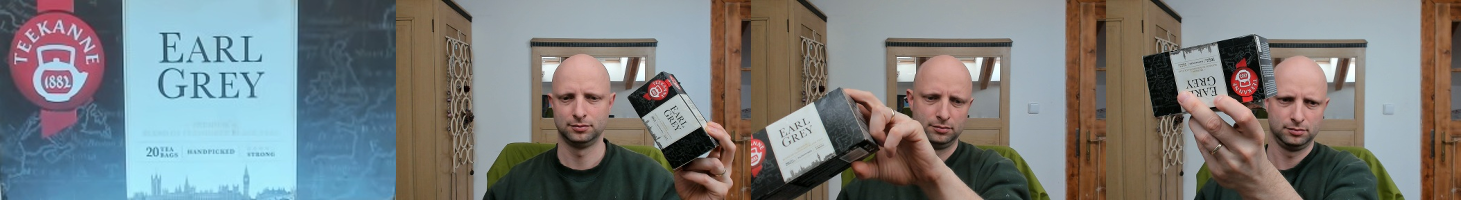

In [ ]:
fitea = glob.glob('./tea*.png')
fitea.sort()
teas = []
for fi in fitea:
  print(fi)
  teas.append(cv.imread(fi))
print('\n')
show_more(200, teas[0], teas[1], teas[2], teas[3])

We will proceed very similarly to the panorama - just use the **SIFT** features now

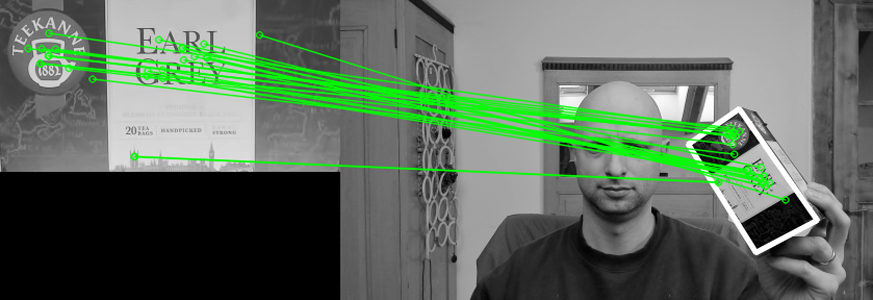

In [ ]:
MIN_MATCH_COUNT = 10
img1 = teas[0]       
img2 = teas[1]

img1 = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)     
img2 = cv.cvtColor(img2, cv.COLOR_BGR2GRAY)     

sift = cv.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1,des2,k=2)

good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()
    h,w = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv.perspectiveTransform(pts,M)
    img2 = cv.polylines(img2,[np.int32(dst)],True,255,3, cv.LINE_AA)
else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None

draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
show(cv.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params), 300)

Let's put it in the class `ObjectDetector`

In [ ]:
class ObjectDetector:
  def __init__(self, img, min_match_count=10):        
    self.detector = cv.SIFT_create()
    self.img = img
    self.img_g = cv.cvtColor(img, cv.COLOR_BGR2GRAY)      
    self.kp, self.des = self.detector.detectAndCompute(self.img_g,None)    

    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)   
    self.matcher = cv.FlannBasedMatcher(index_params, search_params)
    self.min_match_count = min_match_count

  def detect(self, img):
    img_g = cv.cvtColor(img, cv.COLOR_BGR2GRAY)            
    im = img.copy()
    kp, des = self.detector.detectAndCompute(img_g,None)    
    matches = self.matcher.knnMatch(self.des, des, k=2)    
    good = []
    for m,n in matches:
      if m.distance < 0.75*n.distance:
        good.append(m)
    
    if len(good)>self.min_match_count:
      src_pts = np.float32([ self.kp[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
      dst_pts = np.float32([ kp[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
      M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
      matchesMask = mask.ravel().tolist()

      h,w = self.img_g.shape
      pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
      dst = cv.perspectiveTransform(pts,M)
      im = cv.polylines(im, [np.int32(dst)], True, (0, 0, 255), 3, cv.LINE_AA)
      print(f"Enough matches are found - {len(matches_)}")
    else:
      print(f"Not enough matches are found - {len(matches_)}/{self.min_match_count}")
    return(im)

Enough matches are found - 143
Enough matches are found - 143
Enough matches are found - 143


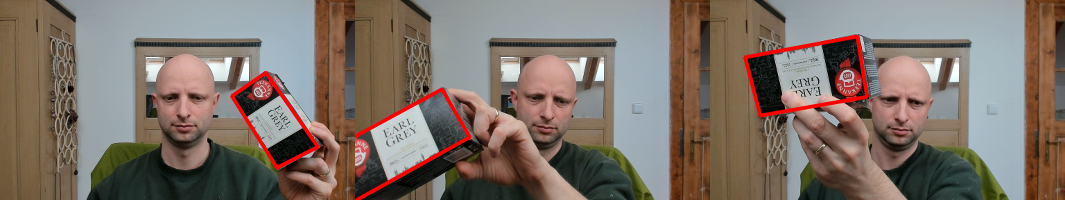

In [ ]:
od = ObjectDetector(teas[0], 10)
show_more(200, od.detect(teas[1]), od.detect(teas[2]), od.detect(teas[3]))

# Part 2: Morphological Transformations


Morphological transformations (MT) are some simple operations based on the image shape. We will discuss these operations only on binary images - in the literature there is also MT for grayscale and color images.

*   Erosion
*   Dilation
*   Opening
*   Closing



./morphology/01.pgm
./morphology/02.pgm
./morphology/03.pgm
./morphology/04.pgm
./morphology/05.pgm
./morphology/06.pgm




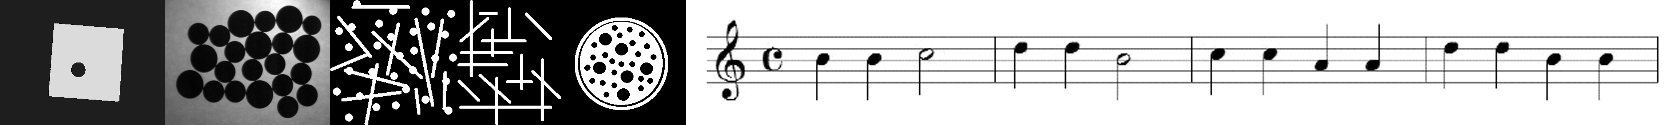

In [ ]:
def circle(r, n):  
  coor = np.arange(-(n-1)/2,(n-1)/2)
  x, y = np.meshgrid(coor, coor)
  m = np.zeros_like(x)
  m[(np.power(x,2) + np.power(y,2)) <= np.power(r,2)] = 1
  return m

fimorph = glob.glob('./morphology/*.pgm')
fimorph.sort()
morphs = []
for fi in fimorph:
  print(fi)
  morphs.append(cv.imread(fi, cv.IMREAD_GRAYSCALE))
print('\n')
show_list(morphs, 125)

## Erosion

<img src='https://staff.utia.cas.cz/novozada/dizo/erosion.png' width=800px/>

We will use convolution:

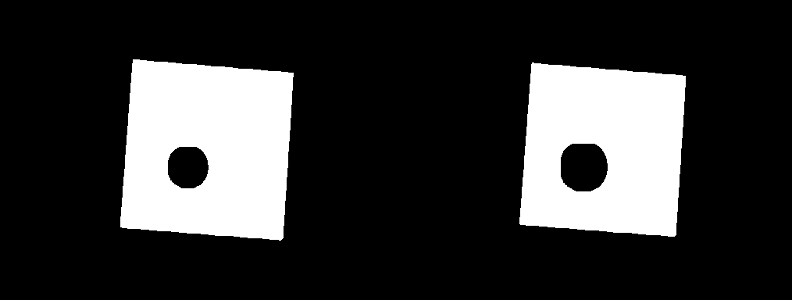

In [ ]:
def erosion(img, se):
  r = cv.filter2D(img, ddepth=-1, kernel=se)  
  n_se = sum(se.flatten())  
  r[r < n_se] = 0
  r[r == n_se] = 1
  return r

struct_elem = circle(5, 10)
show_more(300, erosion(morphs[0], struct_elem)*255, erosion(erosion(morphs[0], struct_elem), struct_elem)*255)

Take a look at the picture - **morpohology/02.pgm**

How many large/small circles are there:

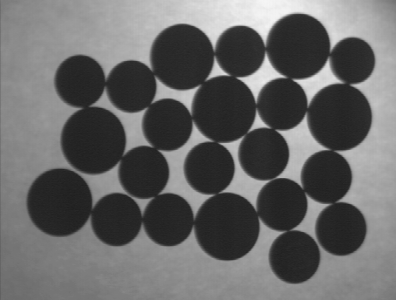

In [ ]:
show(morphs[1], 300)

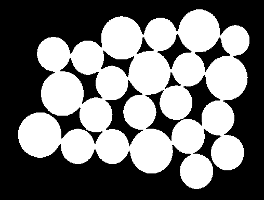

All circles = 9


In [ ]:
_, bi = cv.threshold(morphs[1].copy(), 80, 1, cv.THRESH_BINARY_INV)
show(bi*255)
temp = bi.copy()
contours, hierarchy= cv.findContours(temp, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
circles_all = len(contours)
print(f'All circles = {circles_all}')

If two objects touch, the algorithm considers them to be a single object.
First, we have to use erosion.

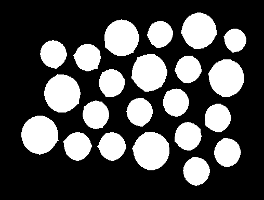

All circles = 22


In [ ]:
temp = bi.copy()
se = circle(7, 14)
temp = erosion(temp, se)
show(temp*255)
contours, hierarchy= cv.findContours(temp, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
circles_all = len(contours)
print(f'All circles = {circles_all}')

To erase the small circles apply erosion several times.

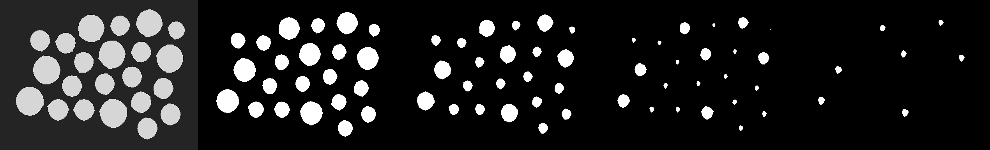

BIG circles = 7
SMALL circles = 15


In [ ]:
temp = bi.copy()
se = circle(7, 14)
imgs_visual = []

for _ in range(5):
  temp = erosion(temp, se)
  imgs_visual.append(temp)

show_list(imgs_visual, 150)
contours, hierarchy= cv.findContours(temp, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
circles_big = len(contours)
print(f'BIG circles = {circles_big}')
print(f'SMALL circles = {circles_all-circles_big}')

Another way that works with the size of objects >> compute their area

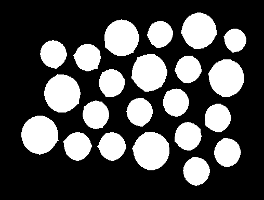

BIG circles = 7
SMALL circles = 15


In [ ]:
temp = bi.copy()
se = circle(7, 14)
temp = erosion(temp, se)
show(temp*255)
contours, _ = cv.findContours(temp, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
circles_big = 0
circles_small = 0
for contour in contours:  
  if cv.contourArea(contour) < 3000:
    circles_small += 1
  else:
    circles_big += 1

print(f'BIG circles = {circles_big}')
print(f'SMALL circles = {circles_small}')

## Dilation

<img src='https://staff.utia.cas.cz/novozada/dizo/dilation.png' width=800px/>

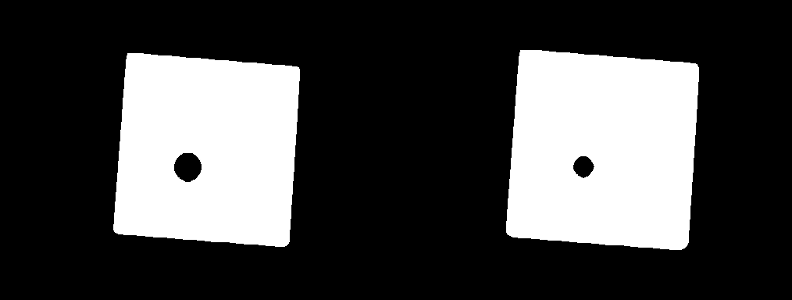

In [ ]:
def dilation(img, se):
  r = cv.filter2D(img, ddepth=-1, kernel=se)    
  r[r > 0] = 1  
  return r

struct_elem = circle(5, 10)
show_more(300, dilation(morphs[0], struct_elem)*255, dilation(dilation(morphs[0], struct_elem), struct_elem)*255)

**Edge detection** using erosion and dilation

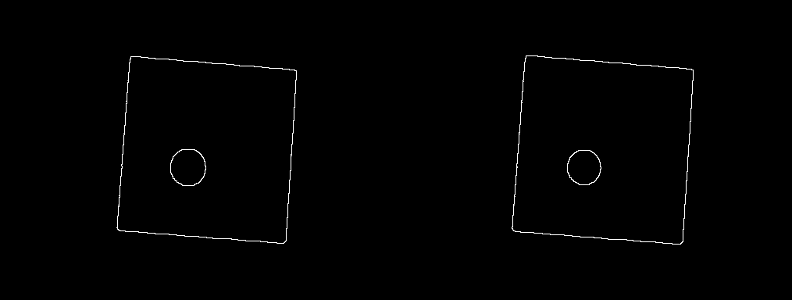

In [ ]:
def edge_erosion(img):
  se = np.ones((3, 3))
  r = erosion(img, se)    
  r = np.abs(img - r)
  return r

def edge_dilation(img):
  se = np.ones((3, 3))
  r = dilation(img, se)    
  r = np.abs(r - img)
  return r

show_more(300, edge_erosion(morphs[0])*255, edge_dilation(morphs[0])*255)

We can see the inner and outer edge of the object.

## Opening

<img src='https://staff.utia.cas.cz/novozada/dizo/opening.png' width=550px/>

*   Program opening and closing
*   Count circles in this image: **morphology/03.pgm**

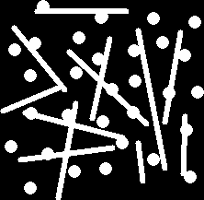

In [ ]:
show(morphs[2]*255)

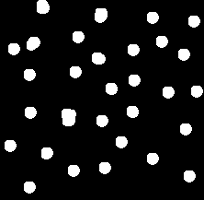

BIG circles = 30


In [ ]:
def opening(img, se):
  return dilation(erosion(img, se), se)

se = circle(6,12)
temp = opening(morphs[2], se)
show( temp * 255)

contours, _ = cv.findContours(temp, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
circles_num = len(contours)

print(f'BIG circles = {circles_num}')

Show only horizontal/vertical lines in this image: **morphology/04.pgm**

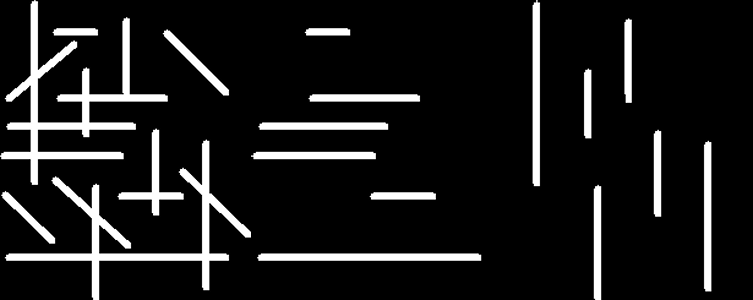

In [ ]:
se = np.ones((1,20))
show_more(300, morphs[3]*255, opening(morphs[3], se)*255, opening(morphs[3], np.transpose(se))*255)

Show only diagonal lines in the same image

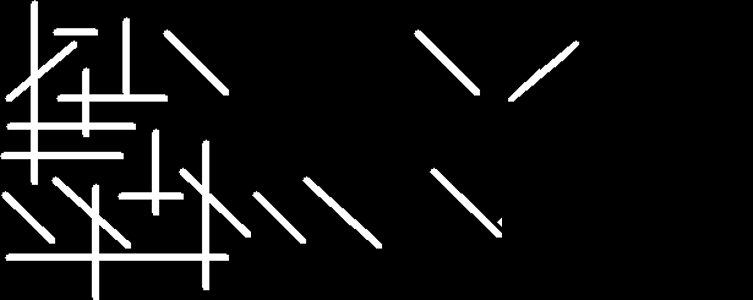

In [ ]:
se = np.eye(13)
show_more(300, morphs[3]*255, opening(morphs[3], se)*255, opening(morphs[3], np.rot90(se))*255)

## Closing

<img src='https://staff.utia.cas.cz/novozada/dizo/closing.png' width=550px/>

In [ ]:
def closing(img, se):
  return erosion(dilation(img, se), se)

Fill in the intermediate rings in the image **morphology/05.pgm**

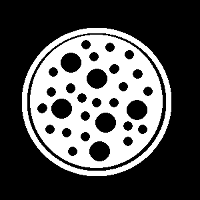

In [ ]:
show(morphs[4]*255)

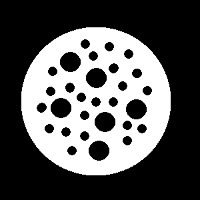

In [ ]:
se = circle(5,12)
show(closing(morphs[4], se)*255)

Fill in the intermediate rings and the small holes

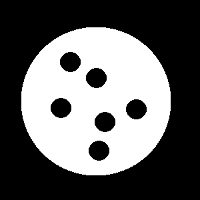

In [ ]:
se = circle(8,18)
show(closing(morphs[4], se)*255)

Erase the five lines in the staff in the image  **morphology/06.pgm**


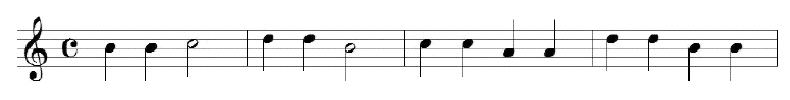

In [ ]:
show(morphs[5],100,interpolation=cv.INTER_NEAREST)

threshold


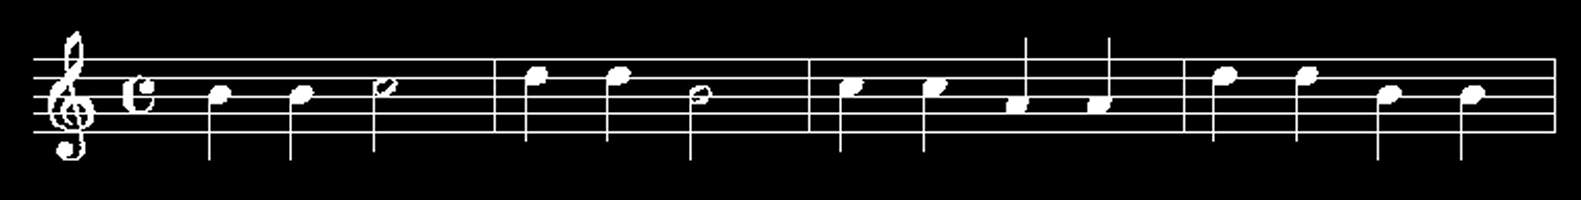

lines


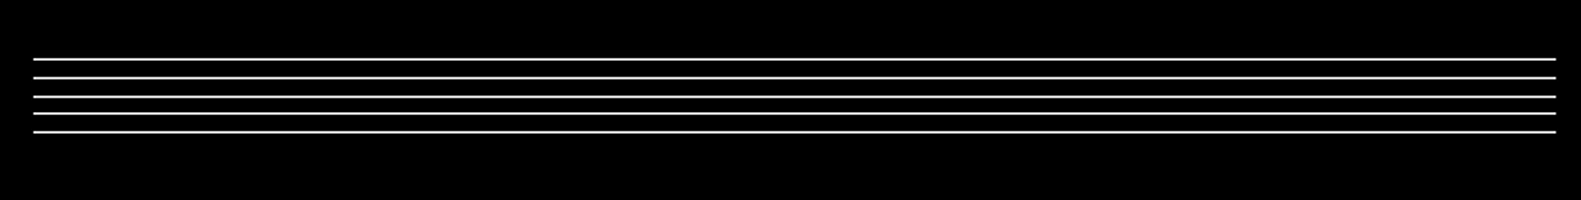

no lines


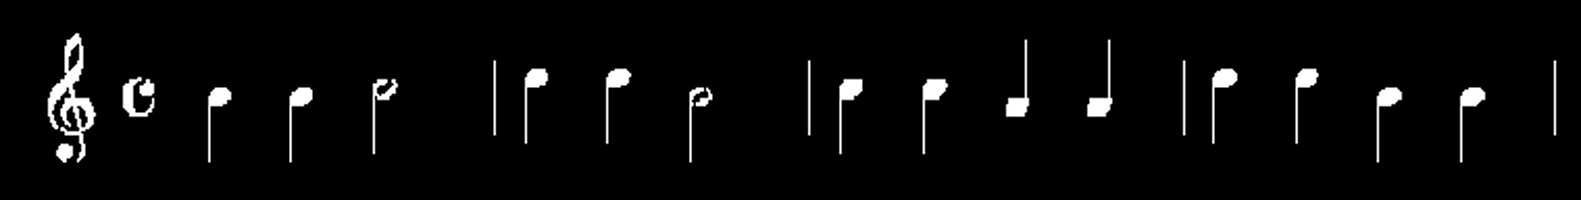

lines masked


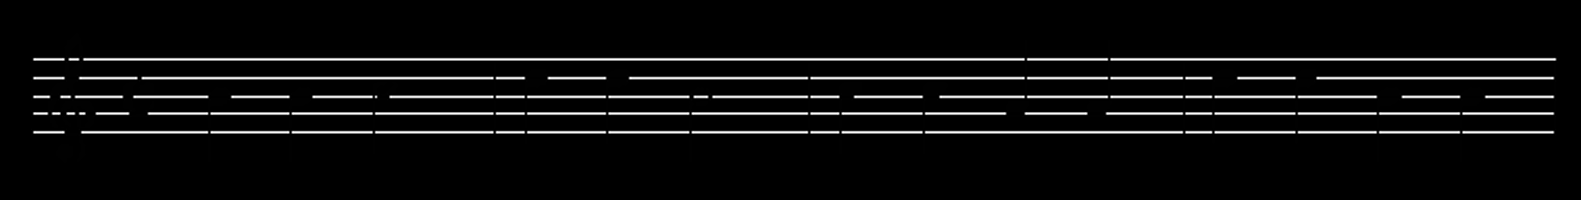

final without lines


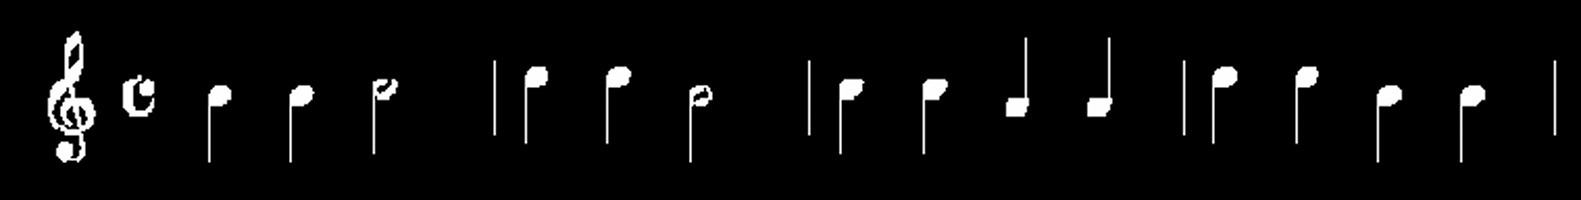

In [ ]:
se = np.ones((1, 15))
_ , temp = cv.threshold(morphs[5], 225, 1, cv.THRESH_BINARY_INV)
print('threshold')
show(temp*255)
print('lines')
lines = opening(temp, se)
show(lines * 255)
print('no lines')
se = np.ones((2, 1))
nolines = opening(temp, se)
show(nolines * 255)
print('lines masked')
lines_masked = lines - nolines
show(lines_masked * 255)
print('final without lines')
show((temp - lines_masked) * 255)

# Part 3: Homework

## ✍🏼 Homework 003.1 - work with pixels

Write a script that creates a single color image from the data in folder **nemo**:

![Ex101.1](https://staff.utia.cas.cz/novozada/dizo/nemos.png)


*   **nemo/red.png** ... red channel
*   **nemo/blue/** ... parts of blue channel
*   **nemo/green/** ... parts of green channel

**<font color='red'>The script will look for positions automatically, not by filename! But I hope that's clear!</font>**
 




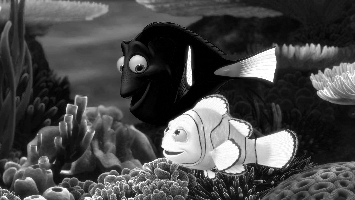

In [ ]:
r = cv.imread('nemo/red.png')
show(r)

nemo/blue/001.png


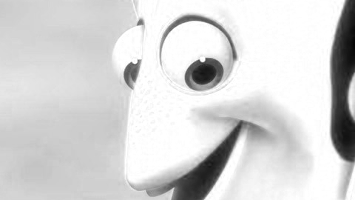

nemo/blue/002.png


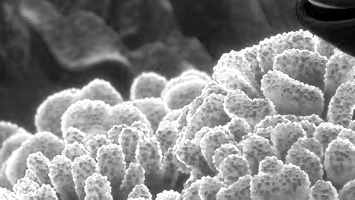

nemo/blue/003.png


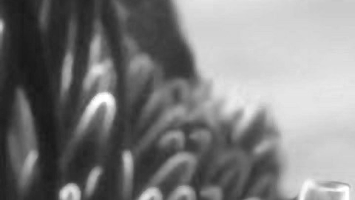

nemo/blue/004.png


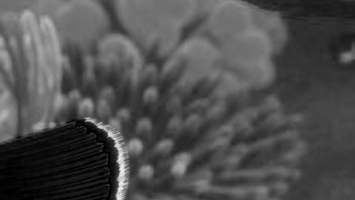

nemo/blue/005.png


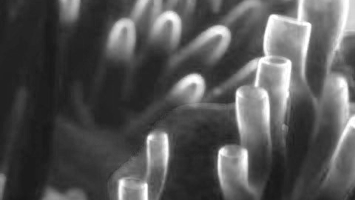

nemo/blue/006.png


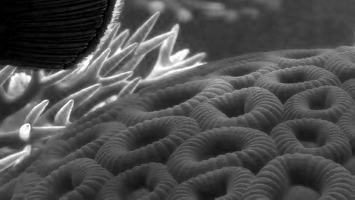

nemo/blue/007.png


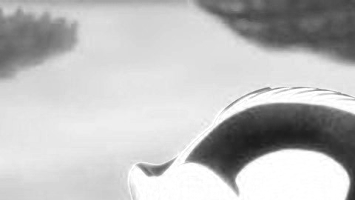

nemo/blue/008.png


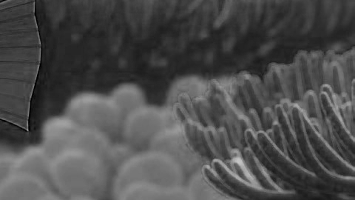

nemo/blue/009.png


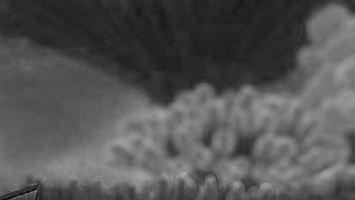

nemo/blue/010.png


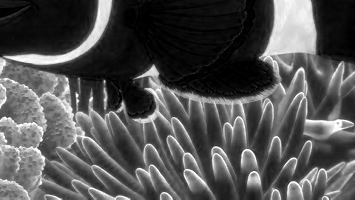

nemo/blue/011.png


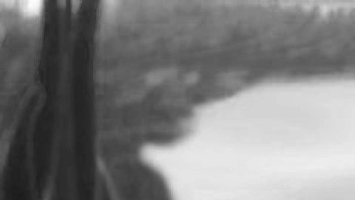

nemo/blue/012.png


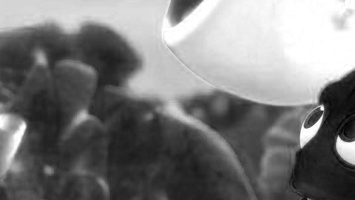

nemo/blue/013.png


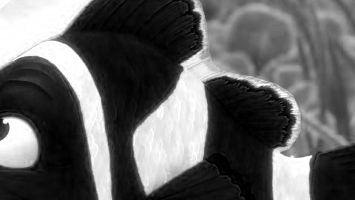

nemo/blue/014.png


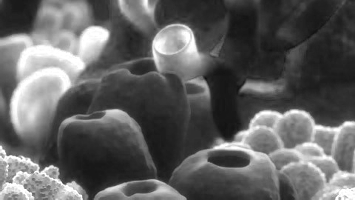

nemo/blue/015.png


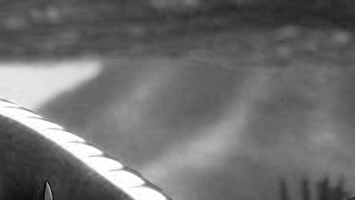

nemo/blue/016.png


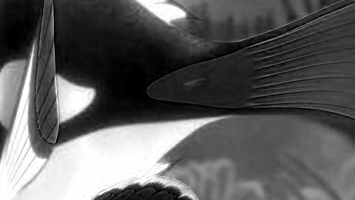

In [30]:
import cv2
# ---------------------------
# YOUR CODE
# ---------------------------
blue_parts = glob.glob('nemo/blue/*.png')
blue_parts.sort()
for i in blue_parts:
  print(i)
  b = cv.imread(i)
  show(b)

## ✍🏼 Homework 003.2

Write a script that calculates how many squares, circles and crosses are in the picture - **objects.png**, regardless of colour and size.

Use only the morphological operations and the OpenCV function [``` cv.findContours() ```](https://docs.opencv.org/3.4/d3/dc0/group__imgproc__shape.html#ga17ed9f5d79ae97bd4c7cf18403e1689a).



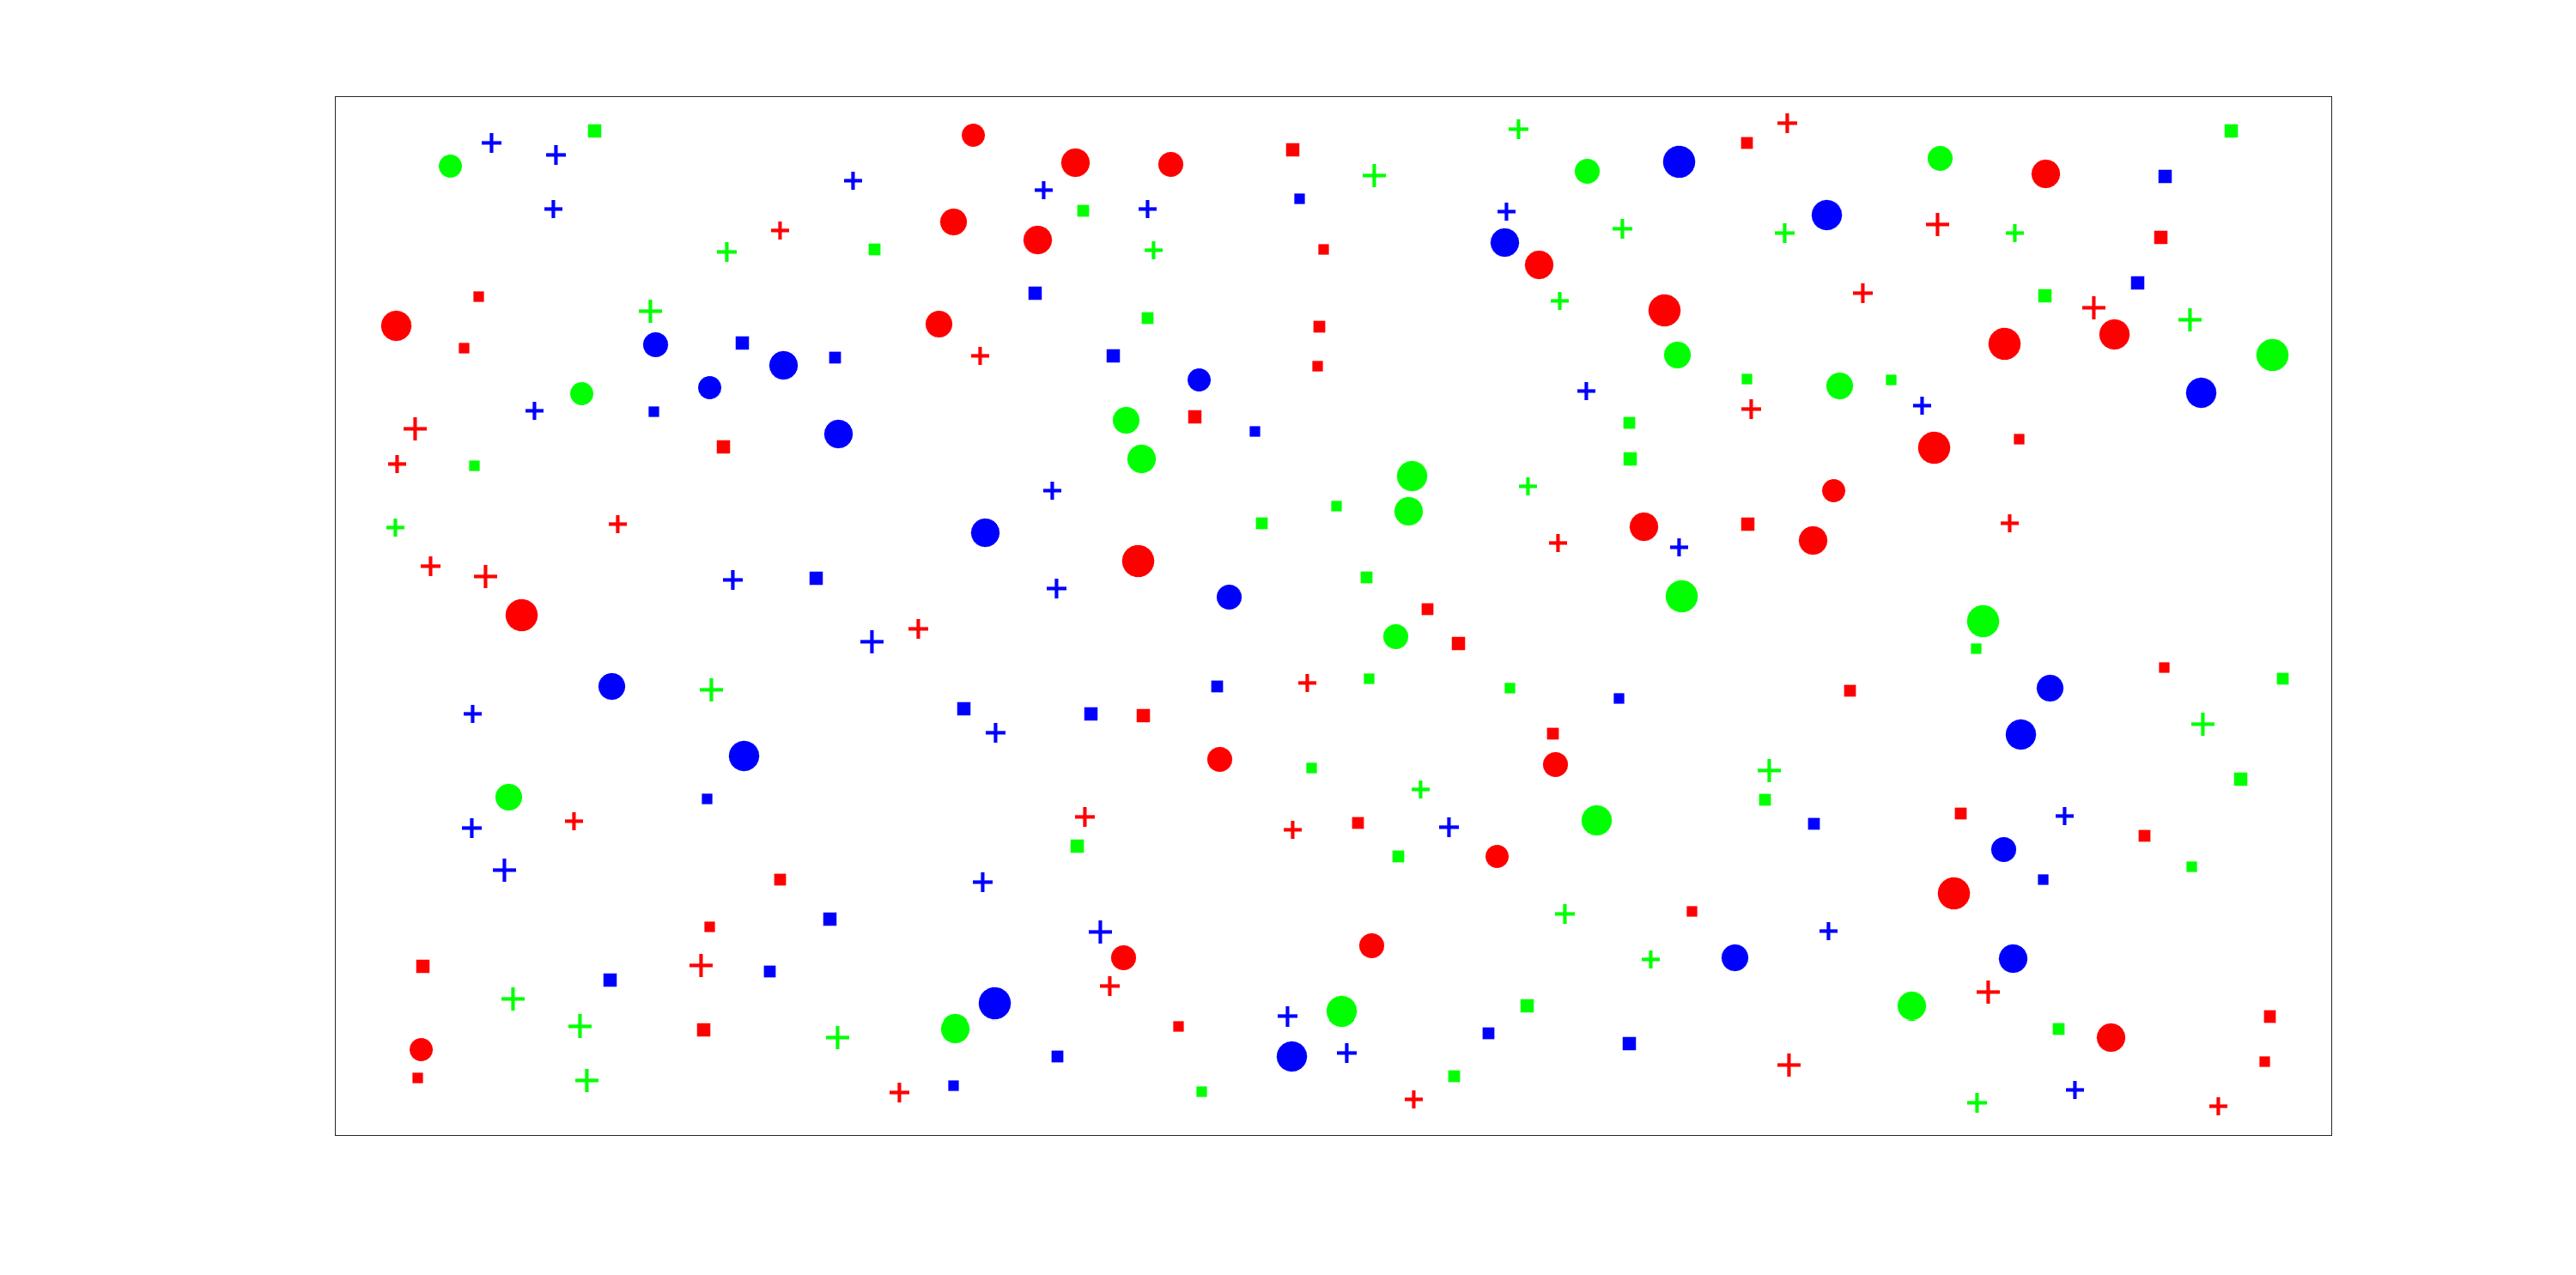

In [ ]:
img = cv.imread('objects.png')
cv2_imshow(img)

In [ ]:
circles = 0
squeres = 0
crosses = 0

# ---------------------------
# YOUR CODE
# ---------------------------

all = circles + squeres + crosses

print(f'circles = {circles}')
print(f'squeres = {squeres}')
print(f'crosses = {crosses}')
print(f'--------------------')
print(f'all ojects = {all}')

circles = 0
squeres = 0
crosses = 0
--------------------
all ojects = 0
